<a href="https://colab.research.google.com/github/CogGal/CogGal/blob/master/StatMethodsPsy20_Lecture5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 5 - How can we test many hypotheses? Setting proper p-values  
## False Detection Rate (FDR) and Permutation tests (Extras - Planned contrasts)

In [ ]:
#@title
import pandas as pd
import seaborn as sns
import numpy as np
import random
import io
import matplotlib.pyplot as plt
from scipy import stats
import statistics
import math 
import itertools as itr
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sns.set(style="white", palette="muted", color_codes=True)
sns.set(rc={'figure.figsize':(10,10)});
sns.set_context("talk")

urlHeight = 'https://raw.githubusercontent.com/uvhart/StatPsyMethods/master/StatMethodsPsy-Lect5.csv'
data = pd.read_csv(urlHeight)


def plot_dist(dist, bins="auto", kde=False, fit="None", color="b", stat="density",height=8, aspect=1):
  #for frequency - set stat to "count"
  #aspect*height=width
  plt.figure(0);
  sns.displot(dist, kde=kde,bins=bins,stat=stat,color=color,height=height, aspect=aspect);
  if (fit=="Normal") & (stat=="density"):  
    d = stats.norm.fit(dist)
    mu = d[0]; sigma = d[1]
    x = np.linspace(mu - 3.5*sigma, mu + 3.5*sigma, 200) #limits of dist
    plt.plot(x, stats.norm.pdf(x, mu, sigma),color="black");
  elif (fit=="F") & (stat=="density"):  
    d = stats.f.fit(dist)
    dfn = d[0]; dfd = d[1]
    interval = stats.f.interval(.995,dfn,dfd) #limits of dist
    x = np.linspace(interval[0],interval[1], 200)
    plt.plot(x, stats.f.pdf(x, dfn, dfd),color="black");
  elif (fit=="gamma") & (stat=="density"):  
    d = stats.gamma.fit(dist)
    a = d[0]; loc = d[1]; scale = d[2]
    interval = stats.gamma.interval(.995,a,loc,scale) #limits of dist
    x = np.linspace(interval[0],interval[1], 200)
    plt.plot(x, stats.gamma.pdf(x, a, loc, scale),color="black");
  elif (fit=="t") & (stat=="density"):  
    d = stats.t.fit(dist)
    a = d[0]; loc = d[1]; scale = d[2]
    interval = stats.t.interval(.995,a,loc,scale) #limits of dist
    x = np.linspace(interval[0],interval[1], 200)
    plt.plot(x, stats.t.pdf(x, a, loc, scale),color="black");


## Question 1: In the ANOVA test we compare:
### A. The variance of all the observations together
### B. The means of the different groups
### C. The mean distances within each group compared with the mean distance between the means of the groups
### D. The total variance compared with the variance of each group alone.

# Slide 1: Last class we discussed how to use ANOVA as a way to check whether there is at least one group that is different from the others. Yet, this analysis does not give us a lot of information about which of the groups is the different one. So if we want to know that as well, we need to use a different approach.

# Slide 2: (Recap) What's the issue with just making lots of comparisons between the groups?
## The problem is that if we do many tests, something would probably come up as being significant just by chance. Especially if there are many groups that we are going to compare. 
### As intuition, consider the probability to get a "6" when you roll a die. If you do it only once, the probablity is 1/6. But if you roll the die many times, the chances of getting at least one "6" are almost 100%. 

# Slide 3: First Example - Heights by Months
### As an example, we will check heights of students (this class data) grouped by the different months students were born. Do you expect to see differences in heights for different months?

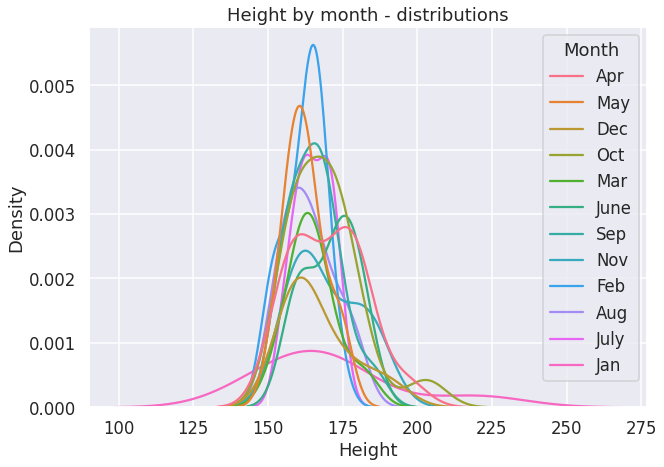

In [ ]:
#@title Heights by the months that students were born
# Take the height data and segement it by month of birth and run many t-tests to see if something is different
heights=data
months=['Jan','Feb','Mar','Apr','May','June','July','Aug','Sep','Oct','Nov','Dec']

#heightByMonth= np.zeros((height[2:,6].size,len(months))) ##prepare matrix, each column is a month

# Use a list comprehension to create list of sliced dataframes
heightByMonth = [heights[heights['Birth Month'] == val] for val in months]
# Iterate through list and plot the sliced dataframe

distributions = {"height":heights['Height'], "Month":heights['Birth Month']}
df = pd.DataFrame.from_dict(distributions);
plt.figure(0,figsize=(10,7))
sns.kdeplot(data=df,x="height",hue="Month");

plt.title(label='Height by month - distributions');
plt.xlabel("Height");
plt.ylabel("Density");




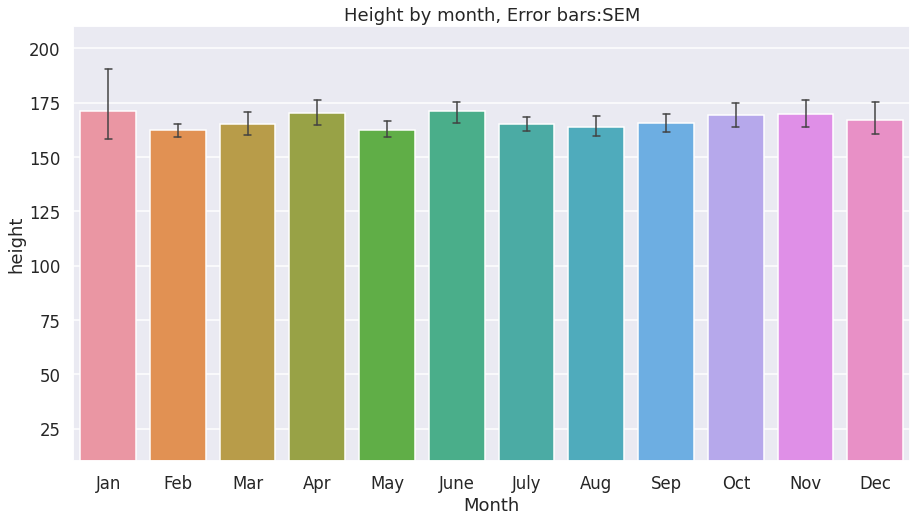

In [ ]:
#@title The mean height and SEM of each month group 
plt.figure(2,figsize=(15,8))
ax = sns.barplot(x='Month', y='height',data=df, ci=95, errwidth=1.5, capsize=.1,order=months);
plt.ylim(10,210);
plt.title(label='Height by month, Error bars:SEM')



Tscores = np.zeros(len(list(itr.combinations(range(12),2))))
pVals = np.zeros(len(list(itr.combinations(range(12),2))))
k=0;
compareList=[]
for i in list(itr.combinations(range(12),2)):###run on all possible comparisons and calculate t scores
  Tscores[k] = (stats.ttest_ind(heightByMonth[i[0]]['Height'],heightByMonth[i[1]]['Height']).statistic)
  pVals[k] = stats.ttest_ind(heightByMonth[i[0]]['Height'],heightByMonth[i[1]]['Height']).pvalue
  compareList.append(i)
  k=k+1


66


<Figure size 432x288 with 0 Axes>

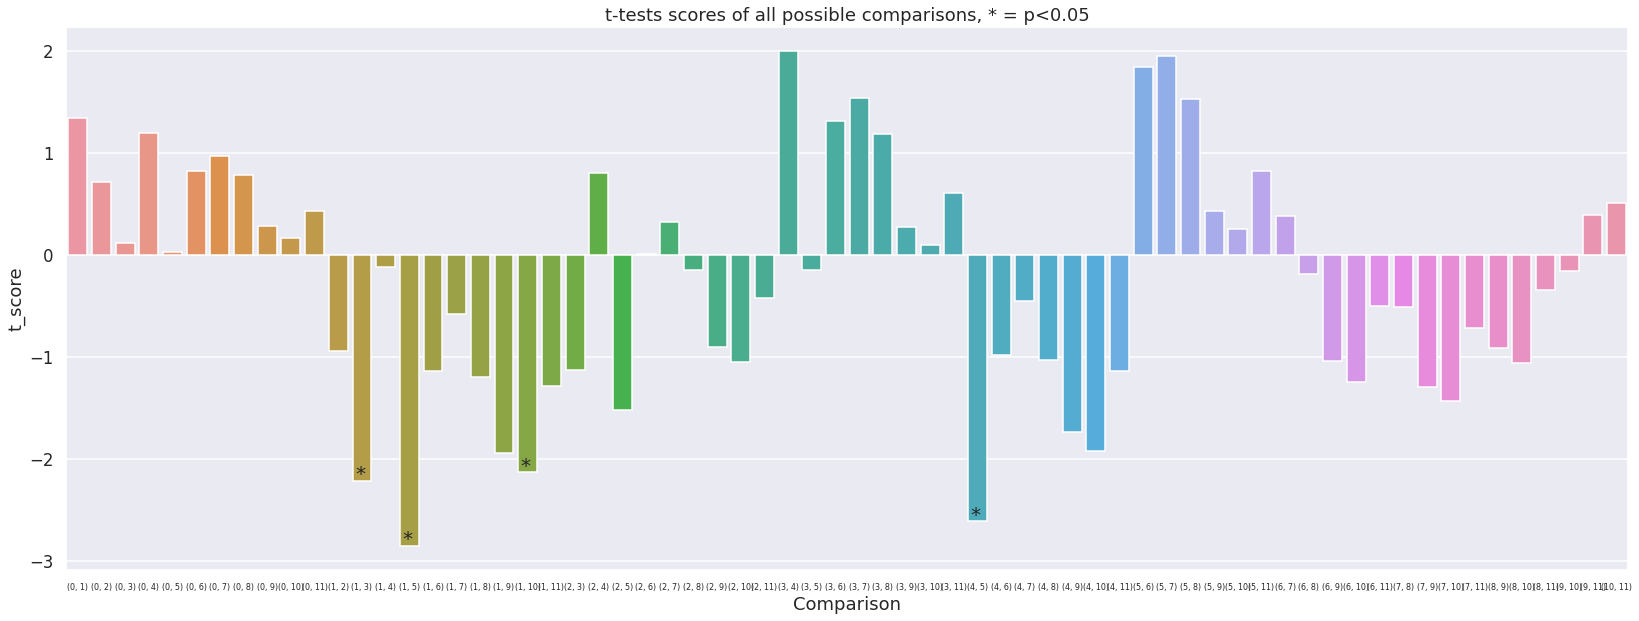

In [ ]:
#@title Because we do many comparisons (66) - we get that several of them are significant (marked by an *)
Tdf = pd.DataFrame({'Comparison': compareList, 't_score': Tscores})
plt.figure(3)
plt.figure(figsize=(28,10));

ax = sns.barplot(x='Comparison', y='t_score', data=Tdf);
ax.tick_params(axis="x", labelsize=8)
plt.title(label='t-tests scores of all possible comparisons, * = p<0.05')
print(len(pVals))
for i in range(len(pVals)):##if the t-test score is significant, show *
  if pVals[i] < 0.05:
    ax.text(i-.3,Tscores[i]+0.01,"*",fontsize=20);

# Slide 4: Second Example - What does your preference of a specific singer say about your height?

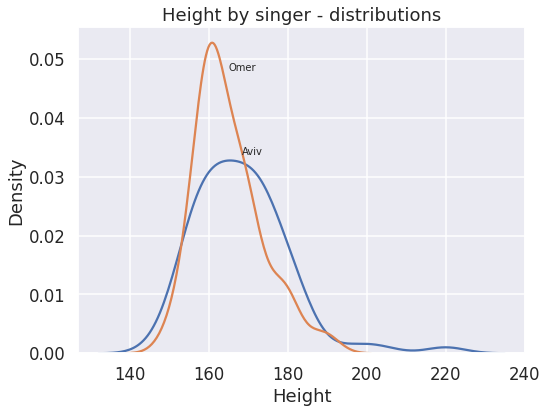

In [ ]:
#@title Another example - choosing a random variable for creating two groups might still get a significant result
# Take the data and separate it to an Aviv Gefen group and an Omer Adam group - then run t-tests on all other questions excluding {favorite color, favorite candy, favorite pet}
# Take the height data and segement it by month of birth and run many t-tests to see if something is different
heights=data
groups=['Aviv','Omer']

# Use a list comprehension to create list of sliced dataframes
heightBySinger = [heights[heights['Omer Adam Aviv Gefen'] == val] for val in groups]
plt.figure(1,figsize=(8,6))
# Iterate through list and plot the sliced dataframe
k=-1
for h in heightBySinger:
  k+=1
  ax1=sns.kdeplot(data=h[['Height']],x="Height")
  ax1.text(np.mean(h[['Height']]),(stats.norm.pdf(np.mean(h[['Height']]),np.mean(h[['Height']]),np.std(h[['Height']]))),groups[k])
plt.title(label='Height by singer - distributions')

###arrange all numeric data
dataNum = pd.DataFrame({'Singer':data['Omer Adam Aviv Gefen'],'Countries':data['Countries visited'],'Height':data['Height'],'Shoe':data['Shoe Size'],'Text':data['Texts per day'],'Whatsapp':data['Whatsapp groups'],'Insta':data['Instagram'],'FaveNum':data['Favorit Number']})
     
Tscores = np.zeros(dataNum.shape[1]-1)
pVals = np.zeros(dataNum.shape[1]-1)
k=0;
compareList=[]
for param,df_param in dataNum.groupby('Singer'): #separate by favorite singer
  if param=='Omer':
    Omer = df_param
  else:
    Aviv = df_param
k=0;
for i in dataNum.columns[1:]:#run on all possible comparisons and calculate t scores
  Tscores[k] = (stats.ttest_ind(Aviv[i],Omer[i]).statistic)
  pVals[k] = stats.ttest_ind(Aviv[i],Omer[i]).pvalue
  compareList.append(i)
  k=k+1

Tdf = pd.DataFrame({'Comparison': compareList, 't_score': Tscores})


<Figure size 432x288 with 0 Axes>

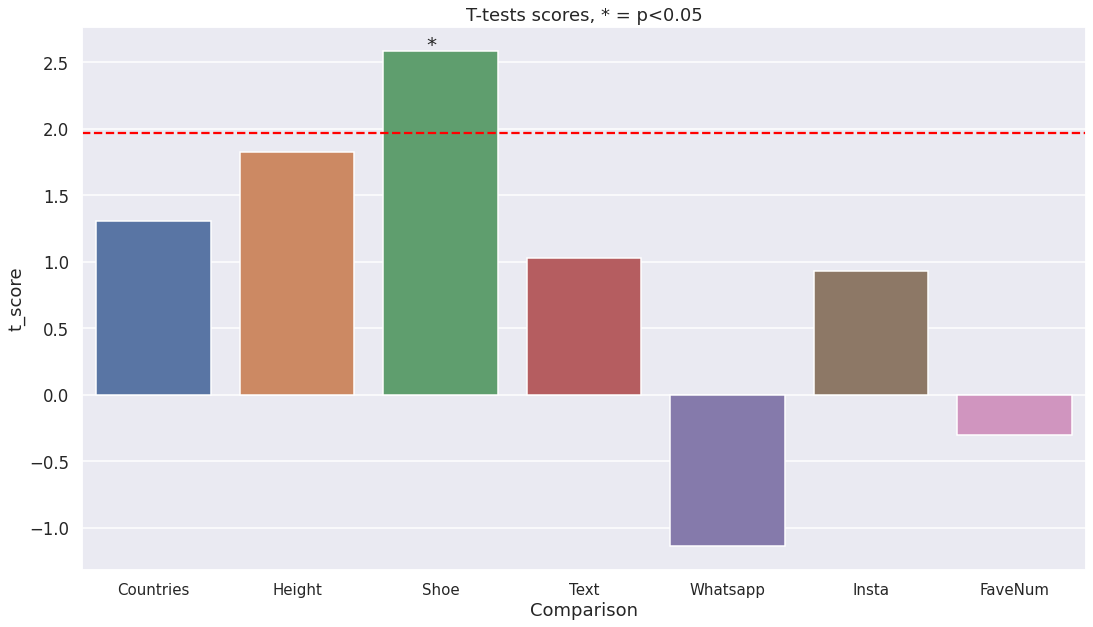

In [ ]:
#@title When doing the above procedure for many such variables (singer, shoe size, facebook friends...) - we get significant differences although we don't expect such an effect to be real
plt.figure(2);
plt.figure(figsize=(18,10));

#plot t-scores
ax = sns.barplot(x='Comparison', y='t_score', data=Tdf);
ax.tick_params(axis="x", labelsize=15);
plt.axhline(y=1.97,color="red",linestyle="dashed", label="Critial t for p-value above (for a two tailed test)");

plt.title(label='T-tests scores, * = p<0.05');

for i in range(len(pVals)):##if the t-test score is significant, show *
  if pVals[i] < 0.05:
    ax.text(i-0.1,Tscores[i]+0.01,"*",fontsize=20);


# Slide 5: Third Example - Random sampling from the same distribution many times

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

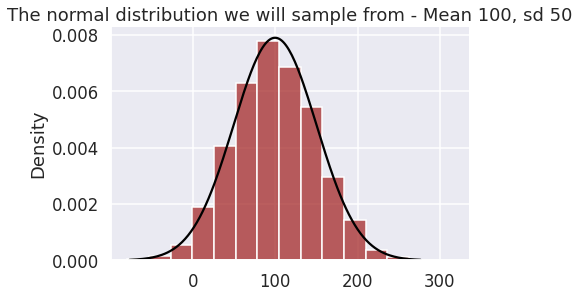

In [ ]:
#@title Comparing many groups, all taken from the same distribution shouldn't yield a significant result

plt.figure(1);##visualize distribution
plot_dist(np.random.normal(100,50,5000), bins=15,color="brown", kde=False, fit="Normal",height=4,aspect=1.6);
plt.title("The normal distribution we will sample from - Mean 100, sd 50");


In [ ]:
#@title But running many tests between the different groups does show some tests that are significant (marked with an *) although they are not real. You can play with the number of samples we take from the same distribution and the critical p-value below which we will consider the result significant. 
def plot_allcompare(criticalP):
  nsamples=10;
  
  criticalP=float(criticalP)
  size=[15 for i in range(nsamples)]##generate N sizes #random.randint(5,70)
  print("Number of combinations:",len(list(itr.combinations(range(nsamples),2))))

  distnum = np.zeros(sum(size*nsamples))
  sep_samples=  []
  np.random.seed(7)
  for i in range(nsamples):##sample n distributions of mean 100 and sd 50, and put them on a vector with labels
    sample = np.random.normal(100,50,size[i])
    sep_samples.append(sample) ##for later calculation of t tests, separate samples
    distnum[i] = i
    
  Tscores = np.zeros(len(list(itr.combinations(range(nsamples),2))))
  pVals = np.zeros(len(list(itr.combinations(range(nsamples),2))))
  k=0;
  compareList=[]
  for i in list(itr.combinations(range(nsamples),2)):###run on all possible comparisons and calculate t scores
    Tscores[k] = (stats.ttest_ind(sep_samples[i[0]],sep_samples[i[1]]).statistic)
    pVals[k] = stats.ttest_ind(sep_samples[i[0]],sep_samples[i[1]]).pvalue
    compareList.append(i)
    k=k+1

  Tdf = pd.DataFrame({'Comparison': compareList, 't_score': Tscores})
  plt.figure(3)
  plt.figure(figsize=(2*nsamples,10));
  ax = sns.barplot(x='Comparison', y='t_score', data=Tdf);
  ax.tick_params(axis="x", labelsize=8)
  
  for i in range(len(pVals)):##if the t-test score is significant, show *
    if pVals[i] < criticalP/2:
      ax.text(i-0.2,Tscores[i]+0.01,"*", fontsize=18);
  plt.title(label='t-tests scores, * = p<'+str(np.round(criticalP,3)),fontsize=20);

inter = interact(plot_allcompare,criticalP="0.05");
inter.widget.children[0].description="Critical p-val";
display(inter);

interactive(children=(Text(value='0.05', description='criticalP'), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_allcompare>

# Slide 6: So the moral of the story is: 
## The more tests we run, the more likely we are to get a single test that would show significant results. For example, if we settle for a p-value of 5%, then runinng many tests (>=20) on different samples from the same distribution would yield a false positive result (Type I error).

## One way to solve this issue is to better control for multiple hypotheses by adjusting the threshold p-value that we consider as significant (changing alpha).

## Question 2: How would you adjust the threshold p-value ($\alpha$) if you run m tests?
### A. Shuffle the data, run m tests, and repeat 10,000 times to get a distribution of p-values. Adjust the threshold p-value such that only 5% of the tests are significant.
### B. Divide the threshold p-value with the number of tests you run ($\alpha_{corrected} = \frac{\alpha_{old}}{m}$)
### C. Rank the p-values by order, match a threshold for each p-value (starting from bonferroni for the smallest and multiply for higher rankings $p_k< k\cdot\frac{\alpha}{m}$), the new threshold would be the highest threshold that a certain p-value managed to be below.
### D. Take $\alpha_{corrected} = \frac{\alpha_{old}}{1000}$, if you get something significant, it's significant. Better safe than sorry.

# Slide 7: So all of them are correct, but what should we choose?

# Slide 8: Bonferroni method: Divide the threshold p-value (alpha, usually 0.05) with the number of tests you run

# Slide 9: What does your preferred singer say about you? (take II)

In [ ]:
#@title
# Take the same data from the candy x singer and show if we get significant results with bonferroni
heights=data
groups=['Aviv','Omer']

# Use a list comprehension to create list of sliced dataframes
heightBySinger = [heights[heights['Omer Adam Aviv Gefen'] == val] for val in groups]
#plt.figure(1)
# Iterate through list and plot the sliced dataframe
#k=-1
#for h in heightBySinger:
#  k+=1
#  ax1=sns.distplot(h[['Height']], hist=False)
#  ax1.text(np.mean(h[['Height']]),(stats.norm.pdf(np.mean(h[['Height']]),np.mean(h[['Height']]),np.std(h[['Height']]))),groups[k])
# plt.title(label='Height by singer - distributions')

###arrange all numeric data
dataNum = pd.DataFrame({'Singer':data['Omer Adam Aviv Gefen'],'Countries':data['Countries visited'],'Height':data['Height'],'Shoe':data['Shoe Size'],'Text':data['Texts per day'],'Whatsapp':data['Whatsapp groups'],'Insta':data['Instagram'],'FaveNum':data['Favorit Number']})
     
Tscores = np.zeros(dataNum.shape[1]-1)
pVals = np.zeros(dataNum.shape[1]-1)
k=0;
compareList=[]
for param,df_param in dataNum.groupby('Singer'): #separate by favorite singer
  if param=='Omer':
    Omer = df_param
  else:
    Aviv = df_param
k=0;
for i in dataNum.columns[1:]:#run on all possible comparisons and calculate t scores
  Tscores[k] = (stats.ttest_ind(Aviv[i],Omer[i]).statistic)
  pVals[k] = stats.ttest_ind(Aviv[i],Omer[i]).pvalue
  compareList.append(i)
  k=k+1

Tdf = pd.DataFrame({'Comparison': compareList, 'T_score': Tscores})


[0.19318547 0.07060366 0.01085675 0.3060208  0.25819177 0.35438181
 0.76321028]


<Figure size 432x288 with 0 Axes>

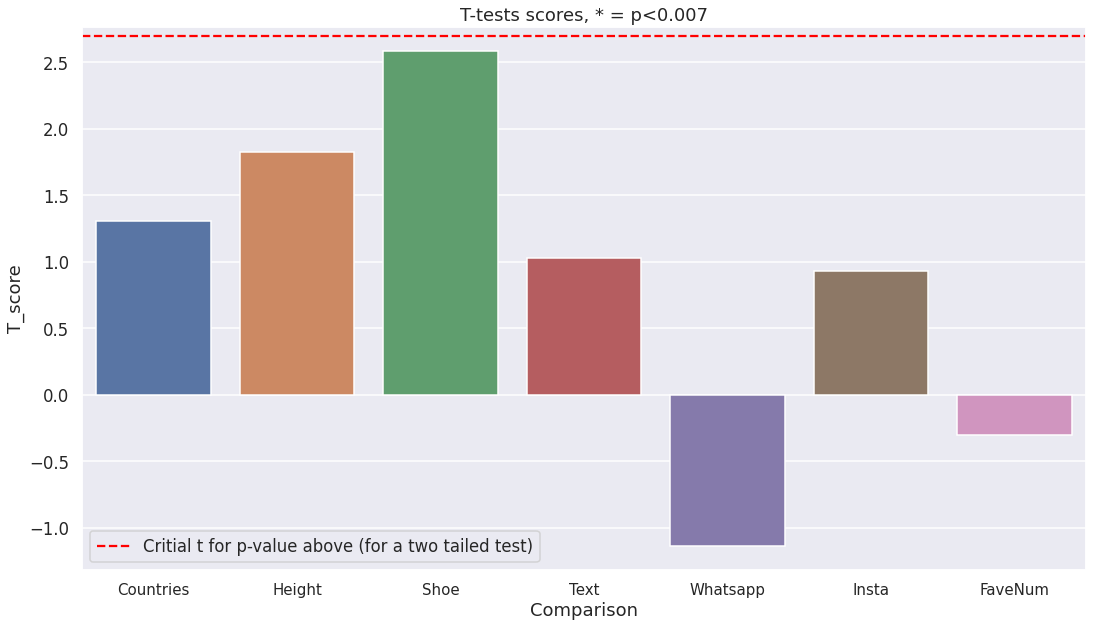

In [ ]:
#@title Omer Adam vs Aviv Gefen fans - all possible comparisons with Bonferroni correction - no test is significant
plt.figure(2);
plt.figure(figsize=(18,10));
#plot t-scores
ax = sns.barplot(x='Comparison', y='T_score', data=Tdf);
ax.tick_params(axis="x", labelsize=15)
plt.axhline(y=2.7,color="red",linestyle="dashed", label="Critial t for p-value above (for a two tailed test)")
plt.title(label='T-tests scores, * = p<0.007')
plt.legend()
print(pVals)
for i in range(len(pVals)):##if the t-test score is significant, show *
  if pVals[i] < 0.05/len(pVals):
    ax.text(i-0.1,Tscores[i]+0.01,"*");


# Slide 10: So the Bonferroni method filters well type I errors (the probability to get an effect decreases significantly). The cost of this method is a larger probability for type II errors (missing true effects in the data).

## Say I have 4 different treatment methods that were found to reduce the score in  the BDI (Beck Depression Inventory) test - I want to know which therapy is better than which. Then I'll have six comparisons: 

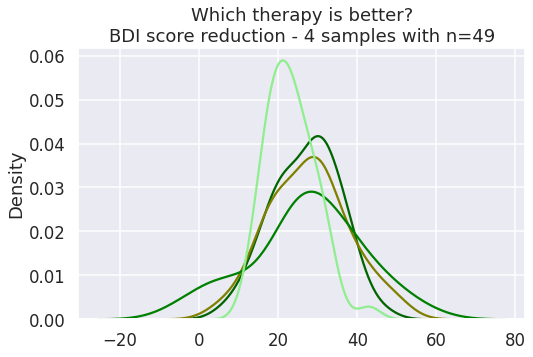

In [ ]:
#@title Here are 4 different groups - are they different or not?


# example where the Bonferroni is too harsh...
np.random.seed(111)
##current experiment tested the influence of different treatments on BDI score:
## BDI - Beck Depression Inventory with scores between 0-63

###experiment results and sampling distributions
accuracy_sampdist1 = np.random.normal(29.8,9/7,5000) ##mean sampling dist accuracy when participants saw the distractor
accuracy_sampdist2 = np.random.normal(27,9/7,5000)  ##mean sampling dist accuracy when they didn't
accuracy_sampdist3 = np.random.normal(26,15/7,5000) ##mean sampling dist accuracy when participants saw the distractor
accuracy_sampdist4 = np.random.normal(25,6/7,5000)  ##mean sampling dist accuracy when they didn't
accuracy_group1 = np.random.normal(29.8,9,49) ##sample dist accuracy when participants saw the distractor
accuracy_group2 = np.random.normal(27,9,49)  ##sample dist accuracy when they didn't
accuracy_group3 = np.random.normal(26,15,49)+0.6 ##sample dist accuracy when participants saw the distractor
accuracy_group4 = np.random.normal(25,6,49)-1.9  ##sample dist accuracy when they didn't

plt.figure(figsize=(8,5));
plt.title("Which therapy is better?\nBDI score reduction - 4 samples with n=49")

sns.kdeplot(accuracy_group1,color='darkgreen');
sns.kdeplot(accuracy_group2,color='olive');
sns.kdeplot(accuracy_group3,color='green');
sns.kdeplot(accuracy_group4,color='lightgreen');


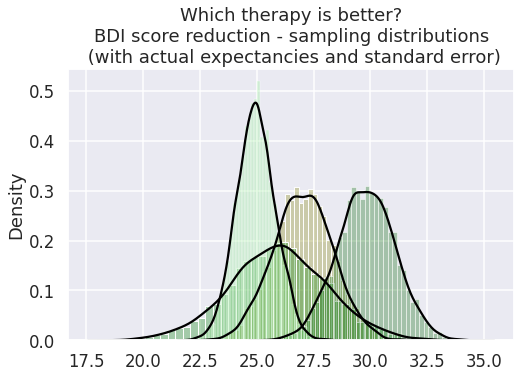

In [ ]:
#@title The distributions from which the **means** where taken (sampling distributions)
plt.figure(figsize=(8,5));

plt.title("Which therapy is better?\nBDI score reduction - sampling distributions\n (with actual expectancies and standard error)")
sns.histplot(accuracy_sampdist2,color='olive',alpha=.3,stat="density");
sns.histplot(accuracy_sampdist3,color='green',alpha=.3,stat="density");
sns.histplot(accuracy_sampdist1,color='darkgreen',alpha=.3,stat="density");
sns.histplot(accuracy_sampdist4,color='lightgreen',alpha=.3,stat="density");
sns.kdeplot(accuracy_sampdist2,color="black",alpha=.3);
sns.kdeplot(accuracy_sampdist3,color="black",alpha=.3);
sns.kdeplot(accuracy_sampdist1,color="black",alpha=.3);
sns.kdeplot(accuracy_sampdist4,color="black",alpha=.3);


In [ ]:
#@title The t-tests between the groups yield the following p-values:

experiments = pd.DataFrame({'Group':['TreatmentA','TreatmentB','TreatmentC','TreatmentC'],
                            'Improvement':[accuracy_group1,accuracy_group2,accuracy_group3,accuracy_group4]})

Tscores = np.zeros(len(list(itr.combinations(range(4),2))))
pVals = np.zeros(len(list(itr.combinations(range(4),2))))
k=0;
compareList=[]

for i in itr.combinations(range(4),2):#run on all possible comparisons and calculate t scores
  Tscores[k] = (stats.ttest_ind(experiments['Improvement'][i[0]],experiments['Improvement'][i[1]]).statistic)
  pVals[k] = stats.ttest_ind(experiments['Improvement'][i[0]],experiments['Improvement'][i[1]]).pvalue
  compareList.append(i)
  k=k+1
print("p-values from all t-tests performed:")
print((Tscores))
print("p-values from all t-tests performed:")
print((pVals))

SortpVals = np.sort(pVals)
Tdf = pd.DataFrame({'Comparison': compareList, 't_score': Tscores})


p-values from all t-tests performed:
[-0.34484116 -0.06891993  2.50160773  0.19486989  2.60847224  1.77017181]
p-values from all t-tests performed:
[0.73096814 0.9451967  0.01405523 0.84590663 0.01054832 0.0798732 ]


<Figure size 432x288 with 0 Axes>

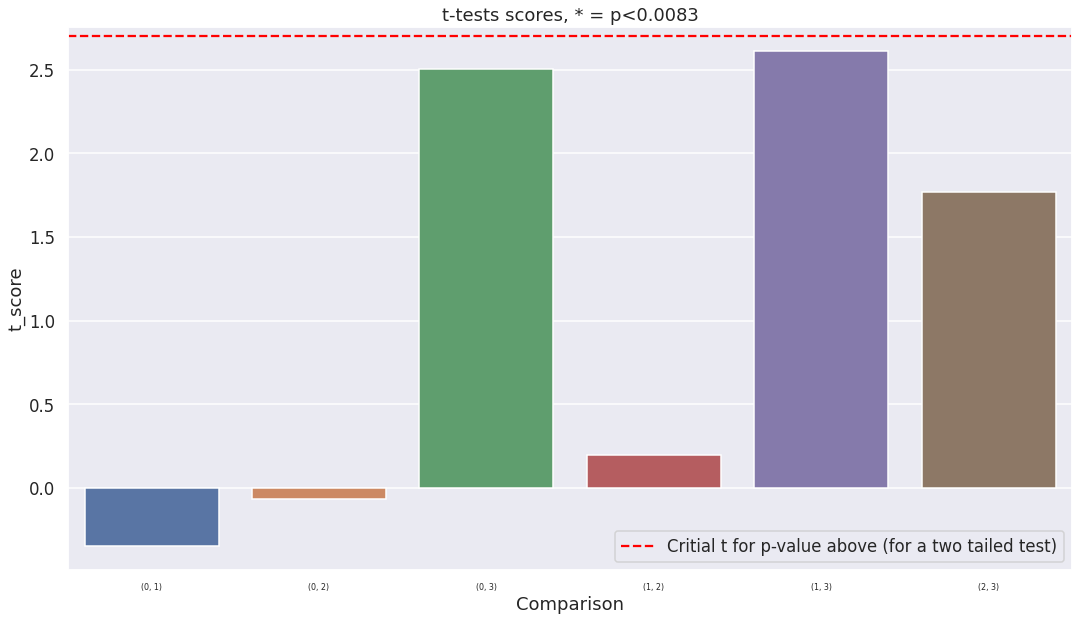

In [ ]:
#@title Performing all possible t-tests with Bonferroni correction - no test is significant (Bonferroni is too harsh)
plt.figure(3)
plt.figure(figsize=(18,10));

#plot t-scores
ax = sns.barplot(x='Comparison', y='t_score', data=Tdf);
ax.tick_params(axis="x", labelsize=8)
plt.axhline(y=2.7,color="red",linestyle="dashed", label="Critial t for p-value above (for a two tailed test)")
plt.legend()
plt.title(label='t-tests scores, * = p<'+str(round(0.05/len(pVals),4)))

for i in range(len(pVals)):##if the t-test score is significant, show *
  if pVals[i] < 0.05/len(pVals):
    ax.text(i-0.1,Tscores[i]+0.01,"*");


# Slide 11: Benjamini-Hochberg method: 
# 1. Rank all p-values from smallest to greatest 
# 2. Calculate an upper threshold for each p-value from the following formula (for the k-th p-value):
## $$ p_k < k \cdot \frac{\alpha}{m} $$
## Where k is the serial number of the p-value (its order in the list of p-values), $\alpha$ is the threshold for the one test case, and m is the number of tests we run.
# 3. Find the largest p-value that holds the equation above
# 4. All p-values that precede this p-value are considered significant.

# Slide 12: Here is an example on how the benjamini-hochberg method works

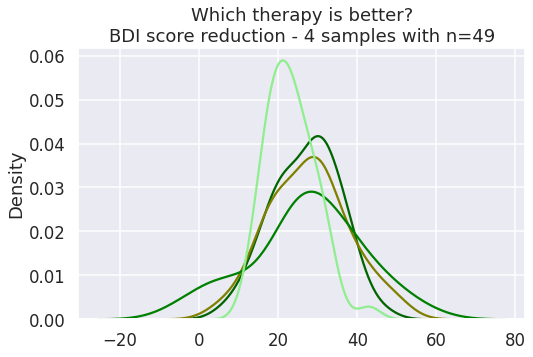

In [ ]:
#@title The same 4 groups from the Bonferroni example

plt.figure(figsize=(8,5));
plt.title("Which therapy is better?\nBDI score reduction - 4 samples with n=49")


sns.kdeplot(accuracy_group1,color='darkgreen')
sns.kdeplot(accuracy_group2,color='olive')
sns.kdeplot(accuracy_group3,color='green')
sns.kdeplot(accuracy_group4,color='lightgreen')

In [ ]:
#@title The Benjamini-Hochberg Method in action (see the table)
# Take a case of 4 samples and all the comparisons between them 
# Show a table of p-values for this case, the table shold have: rank, p-value, p-value threshold
pval_threshold = [((0.05/len(SortpVals))*(i+1)) for i in range(len(SortpVals))]
from tabulate import tabulate
BH = pd.DataFrame({'p-value in experiment' : (SortpVals),
                   'rank' : (np.array(range(1,7))),
                   'p-value threshold' : (pval_threshold)},
                   columns = ['p-value in experiment' ,'rank', 'p-value threshold'])
print(tabulate(BH, headers = ['p-value in experiment' ,'rank', 'p-value threshold']))


      p-value in experiment    rank    p-value threshold
--  -----------------------  ------  -------------------
 0                0.0105483       1           0.00833333
 1                0.0140552       2           0.0166667
 2                0.0798732       3           0.025
 3                0.730968        4           0.0333333
 4                0.845907        5           0.0416667
 5                0.945197        6           0.05


# What is the largest p-value that is below its own threshold?

Critical p-value is: 0.014
      p-value in experiment    rank    p-value threshold  significant?
--  -----------------------  ------  -------------------  --------------
 0                0.0105483       1           0.00833333  True
 1                0.0140552       2           0.0166667   True
 2                0.0798732       3           0.025       False
 3                0.730968        4           0.0333333   False
 4                0.845907        5           0.0416667   False
 5                0.945197        6           0.05        False


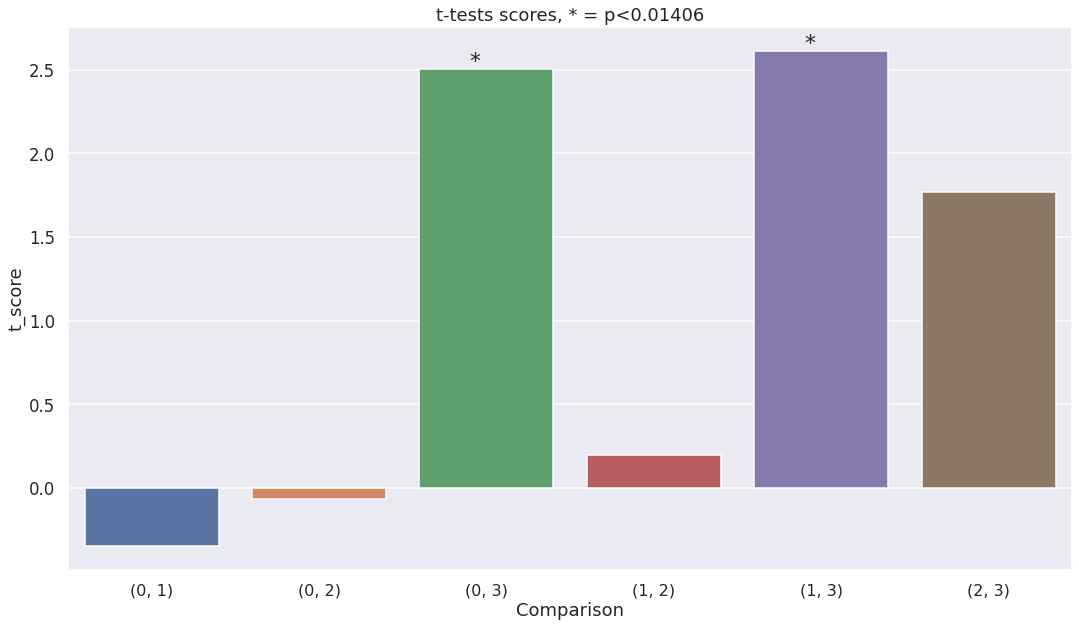

In [ ]:
#@title Find in the table the largest p-value that is still below its own threshold (it and all lower p-values will be significant - marked in an *)
# Show the same table - but with another column: significant or not
p_critic = 0
k=0
for i in (SortpVals):
  if i>=pval_threshold[k]:
    k+=1
    continue
  else: ##if below threshold, it becomes the new pcritic
    k+=1
    p_critic = i

print("Critical p-value is:",np.round(p_critic,3))

BH = pd.DataFrame({'p-value in experiment' : (SortpVals),
                   'rank' : np.array(range(1,7)),
                   'p-value threshold' : pval_threshold,
                   'significant?' : SortpVals<=p_critic},
                   columns = ['p-value in experiment' ,'rank', 'p-value threshold', 'significant?'])
print(tabulate(BH, headers = ['p-value in experiment' ,'rank', 'p-value threshold', 'significant?']))

plt.figure(figsize=(18,10));

#plot t-scores
ax = sns.barplot(x='Comparison', y='t_score', data=Tdf);
ax.tick_params(axis="x", labelsize=16)

plt.title(label='t-tests scores, * = p<'+str(round(p_critic,5)),fontsize=18)
ps=pVals
for i in range(len(ps)):##if the t-test score is significant, show *
  if ps[i] <= p_critic:
    ax.text(i-0.1,Tscores[i]+0.01,"*",fontsize=22);


# Slide 13: Permutations method: Shuffle the data between the groups so that you know it is random. Do all the tests that you plan (over and over again) and see what new threshold for the p-value gives you a 5% (or less, depends on your alpha...) for getting a significant effect (at least one type I error). This is the new p-value threshold.

## The algorithm:
### 1. Put all the K groups you have in one distribution
### 2. Repeat many times:
### 3. Randomly assign observations to K groups
### 4. Run all the comparisons you plan to make AND collect their p-values
### 5. End the loop
### 6. For every p-threshold (0.05,0.02,0.001,...) check the % of times a type I error occured.
### 7. The new treshold will be the p-value for which we got only alpha% of mistakes.



What are the chances to get a mistake by accident with a certain p-value?
Answer is 5% if we choose a thershold p-value of: 0.0102


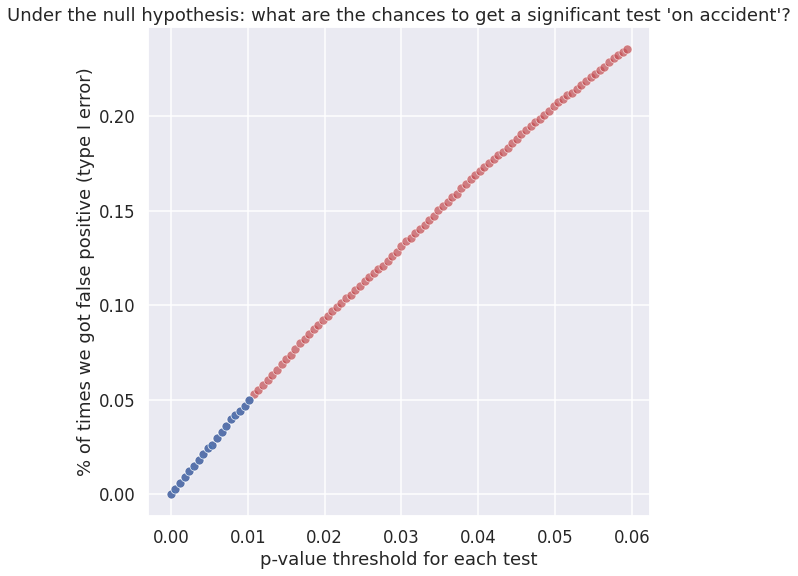

In [ ]:
#@title Finding the threshold p-value by running many tests under the null hypothesis (creating artificial groups) and calculating their p-value distribution
# Show an example for how to calculate the bootstrapped version of the p-value
np.random.seed(3)
pVals=np.zeros((20000,6))
for j in range(20000):
  arr = [accuracy_group1,accuracy_group2,accuracy_group3,accuracy_group4]
  RandData = np.concatenate(arr)
  random.shuffle(RandData) 
  shuffledData = (RandData.reshape(4,len(accuracy_group4)) ) ##random shuffling of the data
  k=0
  for i in itr.combinations(range(4),2):
    pVals[j][k] = (stats.ttest_ind(shuffledData[i[0]],shuffledData[i[1]]).pvalue)
    k+=1
a=[]
sigCount = []##number of significant tests for every threshold
for j in range(100):
  a.append(12*j/20000) ##threshold j values between 0.001 to 0.05
  SigByMis = (sum (np.transpose(pVals)<(12*j/20000)) >0 ) # each permutation gets 1 if at least 1 test was significant
  sigCount.append(np.mean(SigByMis)) ##the mean of the mistake/not mistake vector is the % of times we made at least 1 type I error
plt.figure(figsize=(9,9))
sns.scatterplot(x=a,y=sigCount,color='r', alpha=.7)
a=np.array(a)
sigCount=np.array(sigCount)
#print(pVals)
print("\n\nWhat are the chances to get a mistake by accident with a certain p-value?")
print("Answer is 5% if we choose a thershold p-value of:", max(a[sigCount<0.05]))

sns.scatterplot(x=a[sigCount<0.05],y=sigCount[sigCount<0.05],color='b', alpha=.9)

plt.xlabel("p-value threshold for each test")
plt.ylabel("% of times we got false positive (type I error)")
plt.title("Under the null hypothesis: what are the chances to get a significant test 'on accident'?");

## Question 3: Which method is best to avoid wrong conclusions on multiple hypotheses testing?
### A. Bonferroni - Better safe than sorry when it comes to type I errors
### B. Permutations - It's a natural way to set a proper p-value since we use the same data we have but shuffled.
### C. Benjamini-Hochberg - Better not to miss an effect if it's there. The method is forgiving and so am I.

# Extras

## Slide 15: Method of Sums: Take all p-values such that their sum is still lower than the initial p-value (0.05). This is like filling a cup of size 0.05 with all the p-values that can fit in, starting with the smallest and going to bigger and bigger p-values until the cup is full.

p-values from all t-tests performed:
[0.01054832 0.01405523 0.0798732  0.73096814 0.84590663 0.9451967 ]


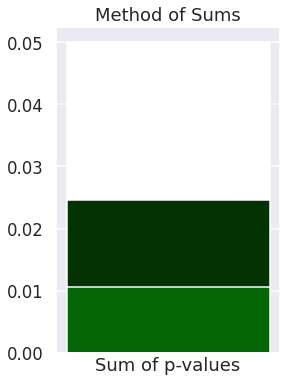

In [ ]:
#@title Method of Sums results for the p-values and their significance 
pVals=ps
print("p-values from all t-tests performed:")
print(np.sort(pVals))
  
sumP = 0;
k=0
pValstacked=[]
for i in (np.sort(pVals)):
  sumP+=i
  if sumP>0.05:
    break
  pValstacked.append(sumP)
  maxSig = i ##will receive the largest pvalue for which significance is determined


#plot t-scores
plt.figure(figsize=(4,6))
plt.bar(height=0.05,x=0 ,color="white")

currsig=0
 
for i in (pValstacked[::-1]): ##plot the p-values on on another
  k+=1
  plt.bar(height=i,x=0,color=(k*0.01,k*0.2,k*0.01))
    
plt.xticks([]);
plt.xlabel("Sum of p-values")
plt.title("Method of Sums");

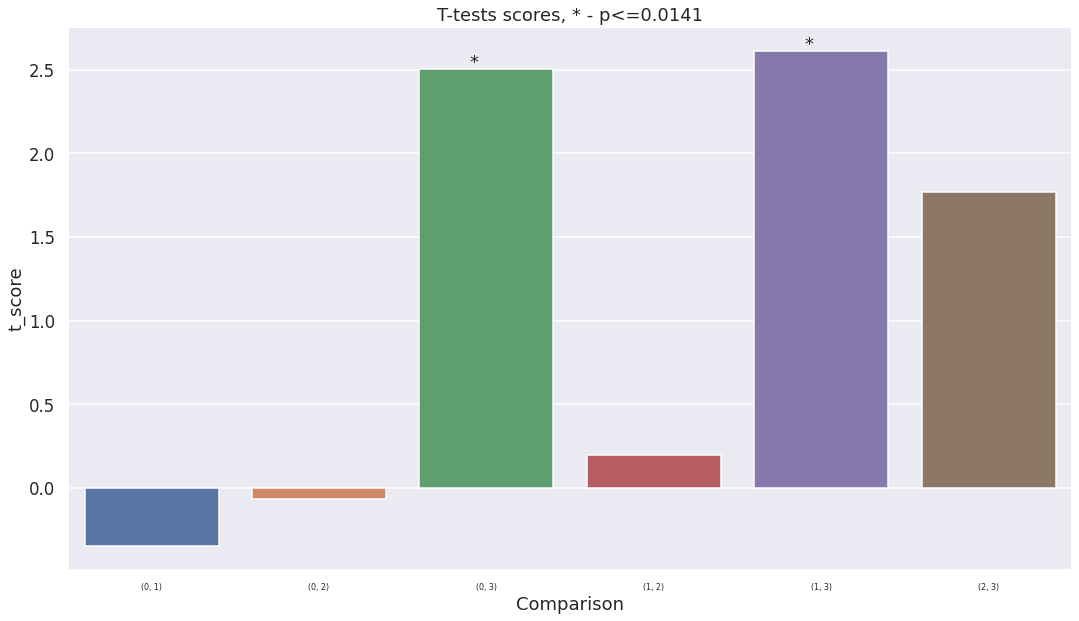

In [ ]:
#@title Marked in an * the significant tests flagged by the Method of Sums (it will usually be close to Benjamini-Hochberg)

plt.figure(2,figsize=(18,10));
ax = sns.barplot(x='Comparison', y='t_score', data=Tdf);
ax.tick_params(axis="x", labelsize=8)
plt.title(label='T-tests scores, * - p<='+str(round(maxSig,4)))

for i in range(len(pVals)):##if the t-test score is significant, show *
  if pVals[i] <=maxSig:
    ax.text(i-0.1,Tscores[i]+0.01,"*",fontsize=18);

## Slide 16: Another completely differernt method is to use *planned contrasts* to create independent hypotheses and check only them. In this way, we carry only tests that we hypothesize might carry significant results. It is important to define these tests before we analyze the data.

## It is costumed today to pre-register these statistical tests in a designated platform such as - 
### AsPredicted (https://aspredicted.org/)
### OSF (https://osf.io/prereg/)

## Slide 17: In the *planned contrasts* case we can compare either two groups, or one group versus all the rest, or two groups against two other groups (and any other linear combination of them). 

## We still need to make sure that we've carried out independent contrasts so there is a limit to how many tests we can do (usually it will be the number of groups we have).

## See more information on planned contrasts here: 
http://homepages.inf.ed.ac.uk/bwebb/statistics/Planned-comparison_post-hoc.pdf